使用pythorch加速运算的lowrankSNN

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
class LowRankSNN(nn.Module):
    # CONSTANTS
    G_L_E = torch.tensor(0.08)
    G_L_I = torch.tensor(0.1)
    G_P= torch.tensor([0.004069, 0.02672, 0.003276, 0.02138]) #g_peak:[E←E, E←I, I←E, I←I]
    V_T = torch.tensor(-55)
    V_R = torch.tensor(-62)
    REV_E = torch.tensor(0)
    REV_I = torch.tensor(-70)
    BIAS = V_T - V_R #Bias current
    C0 = 2/(V_T-V_R)
    C1 = (2*REV_E-V_R-V_T)/(V_T-V_R)
    C2 = (2*REV_I-V_R-V_T)/(V_T-V_R)

    def __init__(self,N_E=1000,N_I=200,RS= 1,taud_E=2,taud_I=5) -> None:
        super().__init__() #调用了父类的方法
        self.N_E = torch.tensor(N_E)
        self.N_I = torch.tensor(N_I)
        self.RS = torch.tensor(RS)
        self.taud_E = torch.tensor(taud_E)
        self.taud_I = torch.tensor(taud_I)
        # self.conn = np.zeros((N_E+N_I,N_E+N_I))
        self.conn = torch.zeros(N_E+N_I,N_E+N_I)
        self.added_lowrank = False
        self.added_random = False
        

    def show(self):
        print('Network Settings')
        print('==========================================')
        print('Number of Neurons: ', self.N_E+self.N_I)
        print('Number of Excitatory Units: ', self.N_E)
        print('Number of Inhibitory Units: ', self.N_I)
        # full_w = torch.mm(self.W, self.mask) #包含兴奋和抑制性信息的连接矩阵
        # full_w = self.W * self.mask
        zero_w = (self.conn == 0).sum().item()
        # pos_w = (self.conn > 0).sum().item()
        # neg_w = (full_w < 0 ).sum().item()
        print('Zero Weights occupy: %2.2f %%'%(zero_w/((self.N_E+self.N_I)**2)*100))
        # print('Positive Weights occupy: %2.2f %%'%(pos_w/(self.N**2)*100))
        # print('Negative Weights occupy: %2.2f %%'%(neg_w/(self.N**2)*100))

    def show_conn(self, maxvalue = 0.001):
        full_w = self.conn.cpu().clone().detach().numpy() #包含兴奋和抑制性信息的连接矩阵
        # let the weight from Inhibitory be negative value
        full_w[:,self.N_E:self.N_E+self.N_I] = -full_w[:,self.N_E:self.N_E+self.N_I]
        colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # 蓝 -> 白 -> 红
        cmap_name = 'gradient_div_cmap'
        gradient_cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)  # N=100 使渐变更加平滑
        plt.imshow(full_w,cmap=gradient_cm,vmax = maxvalue,vmin = -maxvalue)
        plt.colorbar()
        plt.title('Connectivity Matrix')
        plt.xlabel('From')
        plt.xticks(np.arange(0,len(full_w)+1,500))
        plt.ylabel('To')
        plt.yticks(np.arange(0,len(full_w)+1,500))
        plt.gca().xaxis.set_ticks_position('top')
        plt.gca().xaxis.set_label_position('top')
        plt.show()
        

    def add_random(self,conn_rand):
        self.conn_random = conn_rand
        self.conn += conn_rand*self.RS
        self.added_random = True
        print('Random connection has been added.')
        return

    def remove_random(self):
        if not self.added_random:
            print('There is no random connection added.')
            return
        self.conn -= self.conn_random
        del self.conn_random
        self.added_random = False
        print('Random connection has been removed.')
        return

    def add_lowrank(self,conn_LR, W_out):
        self.conn_lowrank = conn_LR
        self.conn += conn_LR
        self.W_out = W_out
        self.added_lowrank = True
        print('Low Rank connection and readout vector have been added.')
        return

    def remove_lowrank(self):
        if not self.added_lowrank:
            print('There is no Low Rank Connectivity added.')
            return
        self.conn -= self.conn_lowrank
        del self.conn_lowrank
        del self.W_out
        self.added_lowrank = False
        print('Low Rank connection and readout vector have been removed.')

    def V2theta(self,V):
        V_R = LowRankSNN.V_R
        V_T = LowRankSNN.V_T
        return 2*torch.arctan((V-(V_R+V_T)/2)*2/(V_T-V_R))

    def theta2V(self,theta):
        V_R = LowRankSNN.V_R
        V_T = LowRankSNN.V_T
        return (V_T+V_R)/2+(V_T-V_R)/2*torch.tan(theta/2)
    
    def to(self, device):
        super().to(device)
        #将有必要的属性转为tensor并移动到指定的device
        self.G_P = self.G_P.to(device)
        self.G_L_E = self.G_L_E.to(device)
        self.G_L_I = self.G_L_I.to(device)
        self.C0 = self.C0.to(device)
        self.C1 = self.C1.to(device)
        self.C2 = self.C2.to(device)
        self.conn = self.conn.to(device)
        self.N_E = self.N_E.to(device)
        self.N_I = self.N_I.to(device)
        self.taud_E = self.taud_E.to(device)
        self.taud_I = self.taud_I.to(device)
        self.W_out = self.W_out.to(device)

        return self
    
    def forward(self,dt,Input):
        # Input size:(N，time)

        if self.conn_lowrank.shape == self.conn_random.shape:
            print('Low-rank connectivity is added to all the connections')
        dt = torch.tensor(dt).to(Input.device)
        G_P = self.G_P
        G_L_E = self.G_L_E
        G_L_I = self.G_L_I
        C0 = self.C0
        C1 = self.C1
        C2 = self.C2
        conn_EE = self.conn[:self.N_E,:self.N_E]
        conn_IE = self.conn[self.N_E:self.N_E+self.N_I,:self.N_E]
        conn_EI = self.conn[:self.N_E,self.N_E:self.N_E+self.N_I]
        conn_II = self.conn[self.N_E:self.N_E+self.N_I,self.N_E:self.N_E+self.N_I]
        V = torch.zeros_like(Input).to(Input.device)
        phase = torch.zeros_like(Input).to(Input.device)
        g = torch.zeros_like(Input).to(Input.device)
        # g_EE = np.delete(np.zeros_like(Input),range(self.N_I),axis=0)
        # g_IE = np.delete(np.zeros_like(Input),range(self.N_E),axis=0)
        # g_EI = np.delete(np.zeros_like(Input),range(self.N_I),axis=0)
        # g_II = np.delete(np.zeros_like(Input),range(self.N_E),axis=0)

        g_EE = g[:self.N_E,:].clone().to(Input.device)
        g_IE = g[:self.N_I,:].clone().to(Input.device)
        g_EI = g[:self.N_E,:].clone().to(Input.device)
        g_II = g[:self.N_I,:].clone().to(Input.device)


        spk = torch.zeros_like(Input).to(Input.device)

        for step, inputs in enumerate(Input.T): #for every time step
            if step == 0: continue

            # Calculate Synaptic Conductance (Single Exponential filter)
            # print(g_EE.device,self.taud_E.device,G_P[0].device,conn_EE.device,spk.device,dt.device)
            g_EE[:,step] = g_EE[:,step-1] + \
                (-g_EE[:,step-1]/self.taud_E+ \
                G_P[0]*conn_EE@spk[:self.N_E,step-1])*dt
            g_EI[:,step] = g_EI[:,step-1] + \
                (-g_EI[:,step-1]/self.taud_E+ \
                G_P[1]*conn_EI@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
            g_IE[:,step] = g_IE[:,step-1] + \
                (-g_IE[:,step-1]/self.taud_I+ \
                G_P[2]*conn_IE@spk[:self.N_E,step-1])*dt
            g_II[:,step] = g_II[:,step-1] + \
                (-g_II[:,step-1]/self.taud_I+ \
                G_P[3]*conn_II@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
            # Calculate the comprehensive Synaptic Conductance (Single Exponential filter)
                # For Excitatory Neurons
            g[:self.N_E,step] = g[0:self.N_E,step-1] + \
                (-g[0:self.N_E,step-1]/self.taud_E+ \
                G_P[0]*conn_EE@spk[:self.N_E,step-1]+ \
                G_P[1]*conn_EI@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
                # For Inhibitory Neurons
            g[self.N_E:self.N_E+self.N_I,step] = g[self.N_E:self.N_E+self.N_I,step-1] + \
                (-g[self.N_E:self.N_E+self.N_I,step-1]/self.taud_I+ \
                G_P[2]*conn_IE@spk[:self.N_E,step-1]+ \
                G_P[3]*conn_II@spk[self.N_E:self.N_E+self.N_I,step-1])*dt

            if torch.any(g<0):
                print('got it')

            # Calculate Membrane Voltage (Phase)
            # For Excitatory Neurons
            phase_pre_E = phase[:self.N_E,step-1]
            phase[:self.N_E,step] = phase_pre_E + (-G_L_E*torch.cos(phase_pre_E)+C0*(1+torch.cos(phase_pre_E))*inputs[:self.N_E]+g_EE[:,step]*(C1*(1+torch.cos(phase_pre_E))-\
                torch.sin(phase_pre_E))+g_EI[:,step]*(C2*(1+torch.cos(phase_pre_E))-torch.sin(phase_pre_E)))*dt
            # For Inhibitory Neurons
            phase_pre_I = phase[self.N_E:self.N_E+self.N_I,step-1]
            phase[self.N_E:self.N_E+self.N_I,step] = phase_pre_I + (-G_L_I*torch.cos(phase_pre_I)+C0*(1+torch.cos(phase_pre_I))*inputs[self.N_E:self.N_E+self.N_I]+g_IE[:,step]*(C1*(1+torch.cos(phase_pre_I))-\
                torch.sin(phase_pre_I))+g_II[:,step]*(C2*(1+torch.cos(phase_pre_I))-torch.sin(phase_pre_I)))*dt

            # Store the firing time
            spk[:,step] = (phase[:,step] >= torch.pi).int()
            phase[:,step][phase[:,step] >= torch.pi] -= 2*np.pi
            

        if self.conn_lowrank.shape == self.conn_random.shape:
            # print(g.T.dtype,self.W_out.dtype,self.N_E.dtype,self.N_I.dtype)
            # print(type(torch.mm(g.T,self.W_out)))
            # print(type(torch.mm(g.T,self.W_out)),type((self.N_E+self.N_I)))
            Out = torch.mm(g.T,self.W_out)/(self.N_E+self.N_I) #Size of g:(N,time), Size of W_out: (N,1)
        V = self.theta2V(phase)
        return Out, V, g, spk



In [22]:
# Function
def Draw_Output(ax,data,label_data,dt,input_data,color_data='#1C63A9'):
    # tt = np.linspace(0,len(data)-1)*dt
    tt = np.array(range(len(data)))*dt
    ax.plot(tt,data,color = color_data, label = '$'+label_data+'$')

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Read Out')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([0, np.max([0.00001,np.max(data),ax.get_ylim()[1]])])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-2,1,alpha = 0.1)
    ax.legend(loc = 1, prop={'size':10})

def Draw_Conductance(ax,data,color_data,label_data,dt,input_data):
    tt = np.array(range(len(data[0])))*dt
    if type(label_data) == list:
        for i in range(len(data)):
            ax.plot(tt,data[i],color = color_data, label = '$'+label_data+'$')
    else:
        ax.plot(tt,np.mean(data,axis=0),color = color_data, label = '$'+label_data+'$')

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Synaptic Conductance (mS/cm^2)')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([0, np.max([0.000001,np.max(data),ax.get_ylim()[1]])])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-2,1,alpha = 0.1)
    ax.legend(loc = 1, prop={'size':10})


def Draw_RasterPlot(ax,data,title_name,dt,input_data,N_E,N_I):
    tt = np.array(range(len(data[0])))*dt
    #Exc
    for row in range(data.shape[0]-N_I):
        spike_times = np.where(data[row]==1)[0]
        # ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, marker='|',color = 'red')
        ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, color = 'red',s=5)

    #Inh
    for row in range(N_E,data.shape[0]):
        spike_times = np.where(data[row]==1)[0]
        # ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, marker='|',color = 'blue')
        ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, color = 'blue',s=5)

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Neuron Index')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([-1, N_E+N_I])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-1,N_E+N_I,alpha = 0.1)
    # ax.legend(loc = 1, prop={'size':10})
    ax.set_title(title_name)



def Draw_Voltage(ax,data,color_data,label_data,dt,input_data):
    # print(len(data) == 0)
    if len(data) == 0: return
    tt = np.array(range(len(data[0])))*dt
    
    if type(label_data) == list:
        for i in range(len(data)):
            ax.plot(tt,data[i],color = color_data, label = '$'+label_data+'$')
    else:
        ax.plot(tt,data[0],color = color_data, label = '$'+label_data+'$')
        for i in range(1,len(data)):
            ax.plot(tt,data[i],color = color_data)

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Voltage (mV)')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([-100, 10])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-100,100,alpha = 0.1)
    ax.legend(loc = 1, prop={'size':10})
    # ax.legend()

def Draw_Projection(ax,activity,direction1,direction2,title_name='Projection',color_line = '#1C63A9',xlabel = 'Activity along Direction1',ylabel = 'Activity along Direction2',ylim = [0,0.005],xlim=[0,0.0006]):
    # Calculate teh projection （using @ to calculate inner multiply）
    # activity: numpy ndarray(N,T), direction1,2: numpy ndarray(N,1)
    act_on_dir1 = activity.T@direction1 # size(T,1)
    act_on_dir2 = activity.T@direction2
    # Draw the graph
    ax.plot(act_on_dir1,act_on_dir2,color = color_line)
    ax.set_title(title_name)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

In [3]:
# Initialiazation
LRSNN = LowRankSNN(N_E=4000,N_I=1000,RS= 1,taud_E=2,taud_I=5)
# LRSNN = LowRankSNN(N_E=5000,N_I=0,RS= 1,taud_E=2,taud_I=5)
# LRSNN = LowRankSNN(N_E=400,N_I=100,RS= 1,taud_E=2,taud_I=5)
# LRSNN = lowrankSNN.LowRankSNN(N_E=500,N_I=0,RS= 1,taud_E=2,taud_I=5)

# LRSNN = LowRankSNN(N_E=400,N_I=100,RS= 0.1,taud_E=2,taud_I=5)
#low rank文献的N=5000
# Go_NoGo Task
# Prepare the Stimuli and Readout Vector
temp = torch.rand(1,LRSNN.N_E+LRSNN.N_I) #Size (1,N_E) for Sti_go and nogo #这里我想试试把Low Rank加到整个网络上
Sti_go = temp.clone()
Sti_nogo = temp.clone()
W_out = temp.clone()
Sti_go[Sti_go>1/3] = 0
Sti_nogo[Sti_nogo<1/3] = 0
Sti_nogo[Sti_nogo>2/3] = 0
W_out[W_out<2/3] = 0

# # Use Gamma Distribution to generate Stimuli and Readout Vector
# # mean and std of Gamma Distribution(Deside Sti_go,Sti_nogo,W_out,conn_rand)
# mu = 1
# si = 10
# b = si**2/mu
# a = mu/b

# Sti_go[Sti_go!=0] = torch.random.gamma(a,b,len(torch.nonzero(Sti_go)[0])) #random.gamma(shape(a), scale(b)=1.0, size=None),这个地方的Gamma分布及其参数选取需要进一步讨论
# Sti_nogo[Sti_nogo!=0] = torch.random.gamma(a,b,len(torch.nonzero(Sti_nogo)[0]))
# W_out[W_out!=0] = torch.random.gamma(a,b,len(torch.nonzero(W_out)[0]))
# W_out = np.transpose(W_out) #Size (N_E,1)
# # Low Rank Connectivity (Rank = 1)
# conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数?
# # Random Connectivity
# conn_rand = torch.random.gamma(a,b,(LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I)) #这里的Gamma分布取值也需要讨论

# Use Folded Gaussian Distribution to generate Stimuli and Readout Vector
std_Sti = 2. #Standerd Deviration of Stimuli
std_Wout = 2. #Standerd Deviration of readout matrix

Sti_go[Sti_go!=0] = torch.abs(torch.normal(mean=0,std=std_Sti,size=(len(torch.nonzero(Sti_go)),)))
Sti_nogo[Sti_nogo!=0] = torch.abs(torch.normal(mean = 0,std = std_Sti,size = (len(torch.nonzero(Sti_nogo)),)))
W_out[W_out!=0] = torch.abs(torch.normal(mean = 0,std = std_Wout,size = (len(torch.nonzero(W_out)),)))
W_out = np.transpose(W_out) #Size (N,1)
conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数? # Low Rank Connectivity (Rank = 1)
conn_rand = torch.abs(torch.normal(0,1/(LRSNN.N_E+LRSNN.N_I),(LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I))) # Random Connectivity

m = W_out #m = Wout
n = Sti_go #n = Stigo

# Assemble the Network
LRSNN.add_lowrank(conn_LR, W_out)
LRSNN.add_random(conn_rand)


Low Rank connection and readout vector have been added.
Random connection has been added.


Network Settings
Number of Neurons:  tensor(5000)
Number of Excitatory Units:  tensor(4000)
Number of Inhibitory Units:  tensor(1000)
Zero Weights occupy: 0.00 %


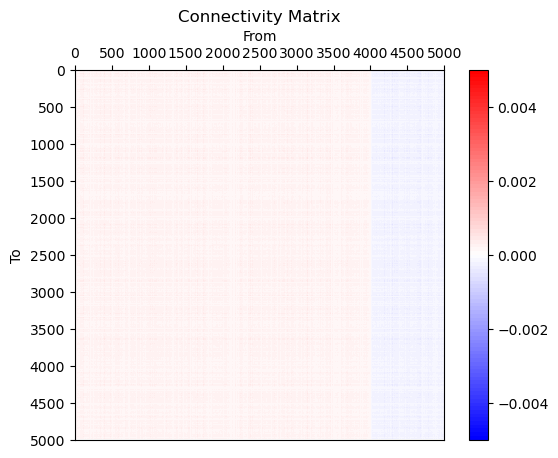

In [4]:
# Show the Network information before simulaiton
# LRSNN = LowRankSNN(N_E=400,N_I=100,RS= 1,taud_E=2,taud_I=5)
LRSNN.show()
LRSNN.show_conn(maxvalue=0.005)

In [5]:

dt = 0.01 #(ms/step)
T_pre = 5 # length of time before sti (ms)
T_sti = 10 # length of time for sti (ms)
T_after = 15 # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms
IS = 1 #Input Strength

Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go.T
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo.T

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)

# Start Simulation
Out_go, V_go, g_go, spk_go = LRSNN(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN(dt,Input_nogo)


Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [137]:

prop = torch.max(Out_go)/torch.max(Out_nogo)
print('Performance: ', prop.item())


Performance:  9.370097160339355


In [11]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

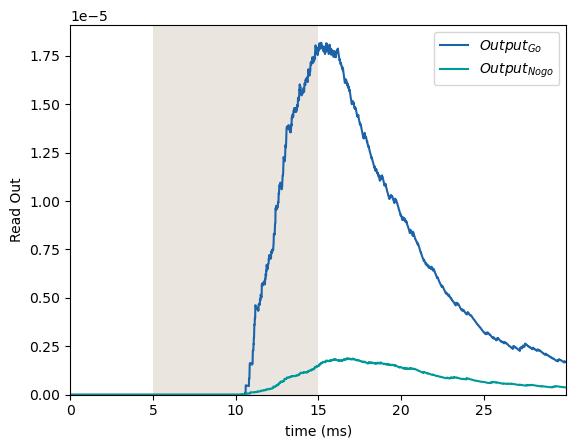

In [14]:

# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

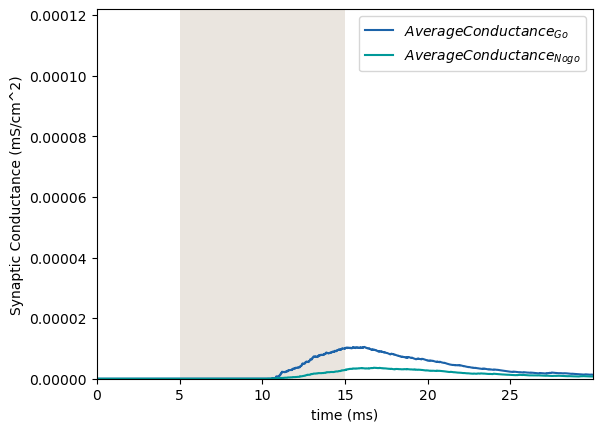

In [17]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go)
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo)

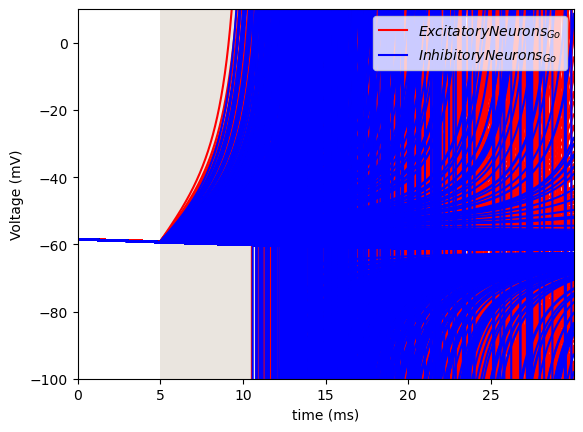

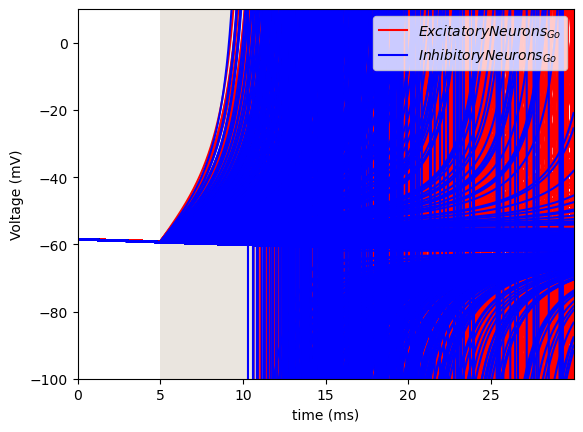

In [19]:
# Monitor the Voltage
fig, ax = plt.subplots()
Draw_Voltage(ax,V_go[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_go)
Draw_Voltage(ax,V_go[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_go)
fig, ax = plt.subplots()
Draw_Voltage(ax,V_nogo[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_nogo)
Draw_Voltage(ax,V_nogo[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_nogo)

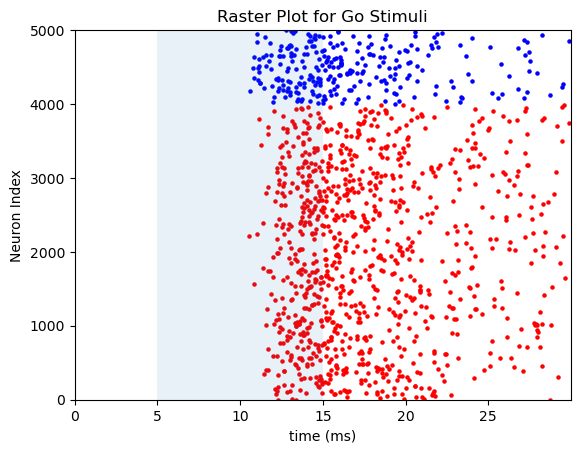

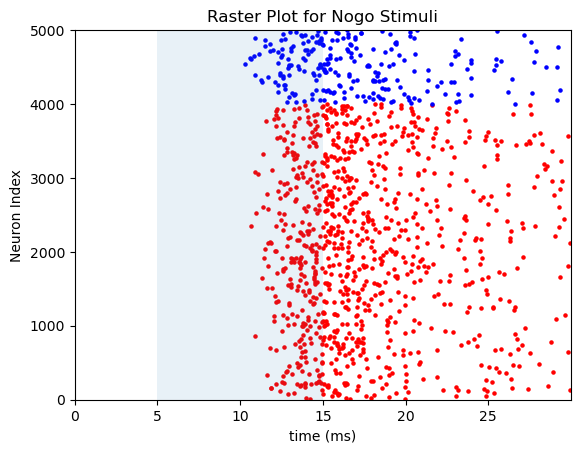

In [23]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

TypeError: unsupported operand type(s) for @: 'numpy.ndarray' and 'Tensor'

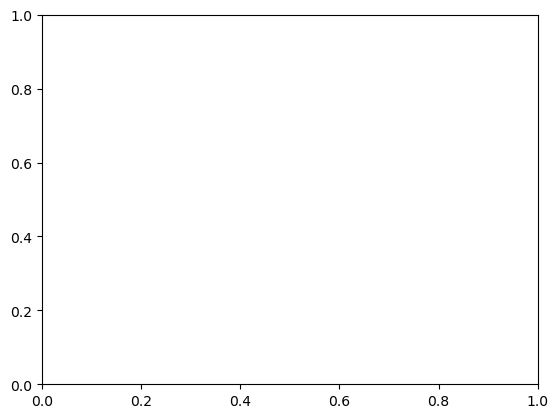

In [24]:
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m')
fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m')